# MCMC Demonstration

Markov Chain Monte Carlo is a useful technique for fitting models to data and obtaining estimates for the uncertainties of the model parameters.

There are a slew of python modules and interfaces to do MCMC including:

* [emcee](http://dan.iel.fm/emcee/current/)
* [PyMC](https://pymc-devs.github.io/pymc/)
* [pymultinest](https://github.com/JohannesBuchner/PyMultiNest)

emcee is fairly straightforward to use, so this demonstration is written to use that. pymultinest is worth investigating if you have large numbers of parameters (say, > 30) and/or multi-nodal solution spaces.

## Required Packages

For this demo you should have the following packages installed (in addition to standard ones like numpy, scipy, matplotlib, and astropy):

* [emcee](http://dan.iel.fm/emcee/current/user/install/)
* [corner](https://github.com/dfm/corner.py)

Optionally, install the [dust_emissivity](https://github.com/keflavich/dust_emissivity/) package for the last section, on fitting a blackbody.

## Demo Overview

This demo will proceed very simply, and will follow the [emcee tutorial](http://dan.iel.fm/emcee/current/user/line/) for fititng a line. At the end is a short, astrophysical example, which includes non-flat priors.

## Preliminaries

In [113]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

Emcee has multithreadding support. Set this to the number of cores you would like to use. In this demo we will use the python `multiprocessing` module support built in to emcee. Emcee can also use MPI if you're working on a cluster and want to distribute the job across nodes. See the documentation for that.

In [114]:
nthreads = 3

## Fitting a Line

### Generate and Plot Some Random Data

Give it both x and y errors.

In [115]:
# define our true relation
m_true = 1.7
b_true = 2.7
f_true = 0.3

In [116]:
# generate some data
N = 30
x = np.sort(10*np.random.rand(N))
yerr = 0.2+0.6*np.random.rand(N)

y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)

y += yerr * np.random.randn(N)

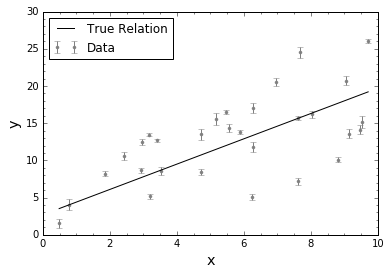

In [117]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

### Least-Squares Fit

(ignoring the x-errors)

In [118]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print('Least squares fitting result:')
print('slope: {0:1.2f}'.format(m_ls))
print('y-intercept: {0:1.2f}'.format(b_ls))

Least squares fitting result:
slope: 1.21
y-intercept: 6.40


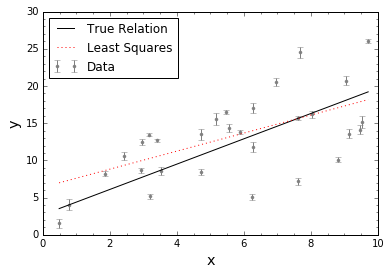

In [119]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.plot(x, m_ls * x + b_ls,
        color='red',
        ls=':',
        label='Least Squares')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

### Maximum likelihood

So, we need to define a likelihood function.

In [120]:
import scipy.optimize as op

In [121]:
def lnlike(theta, x, y, yerr):
    b, m, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [122]:
# let's make some initial guesses for our parameters
# remember this is now theta and b_perp
p2 = [b_true, m_true, f_true]
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll,
                     p2,
                     args=(x, y, yerr))
if not(result['success']):
    print("Max likelihood failed.")
    print(result['message'])

ml_b, ml_m, ml_f = result['x']

In [123]:
print("Maximum likelihood result:")
print("slope: {0:1.2f}".format(ml_m))
print("y-intercept: {0:1.2f}".format(ml_b))
print("ln(f): {0:1.2f}".format(ml_f))

Maximum likelihood result:
slope: 1.61
y-intercept: 3.91
ln(f): -1.11


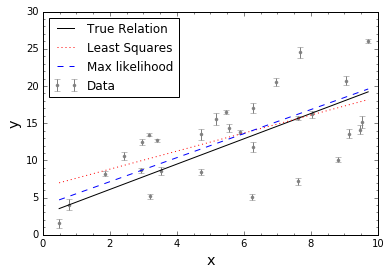

In [124]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.plot(x, m_ls * x + b_ls,
        color='red',
        ls=':',
        label='Least Squares')
ax.plot(x, ml_m * x + ml_b,
        color='blue',
        ls='--',
        label='Max likelihood')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

### What about the Errors?

This is where MCMC comes in. But we need to add some priors for the parameters and use those priors 

In [125]:
def lnprior(theta):
    b, m, lnf = theta
    if lnf >= 0.0:
        return -np.inf
    return 0.0

In [126]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [127]:
# now let's set up the MCMC chains
ndim = 3
nwalkers = 500
steps = 500

In [128]:
# initialize the walkers to the vicinity of the parameters derived from
# ML
pos = [result["x"] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [129]:
# initialze the sampler
sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob,
                                args=(x,
                                      y,
                                      yerr),
                                threads=nthreads)

In [130]:
# go! go! go!
# run the sampler for 500 steps
sampler.run_mcmc(pos, steps)
samples = sampler.chain

That took about 10 seconds on my desktop (3.4 GHz Core i7).


What is the acceptance rate? Lore has it that this should be between $0.3-0.5$.

In [131]:
print("Mean acceptance rate is: {0:1.2f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance rate is: 0.65


This acceptance rate is okay. If it is too low, the emcee documentation suggests increasing the number of walkers until the acceptance fraction is at the desired level.

Let's visualize the chains.

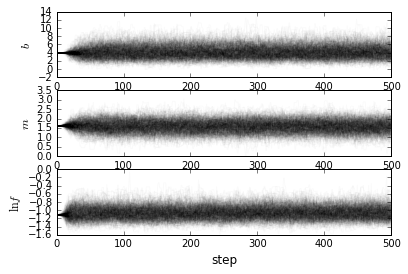

In [132]:
fig = plt.figure()
dim_name = [r'$b$', r'$m$', r'$\ln f$']
for dim in range(ndim):
    ax = fig.add_subplot(ndim, 1, dim+1)
    for i in range(nwalkers):
        ax.plot(np.arange(steps),
                samples[i, :, dim],
                ls='-',
                color='black',
                alpha=10./nwalkers)
    ax.set_ylabel(dim_name[dim], fontsize='large')
ax.set_xlabel('step', fontsize='large')

It looks like the walkers have "burned in" by 50 steps, so keep only those samples after 50 steps.

In [133]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

What does this look like? Let's visualize with the traditional corner plot.

I will give it the actual line parameters with the "truths" parameter, so we can see how our results compare to the actual values.

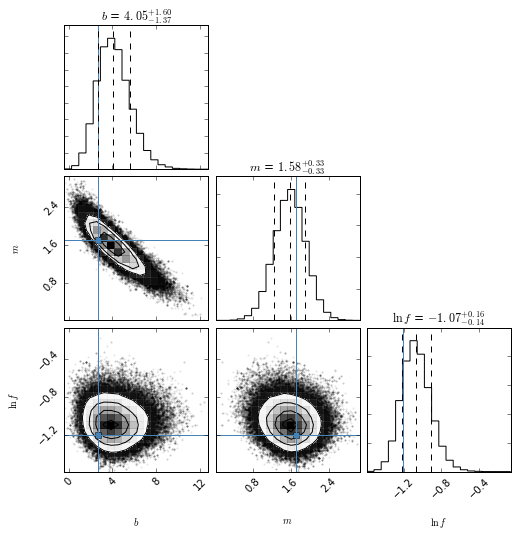

In [134]:
fig = corner.corner(samples,
                    labels=[r"$b$", r"$m$", r"$\ln\,f$"],
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[b_true,
                            m_true,
                            np.log(f_true)],
                    show_titles=True)

Now let's plot a bunch of sample fits from the MCMC chain, on top of our data and other models.

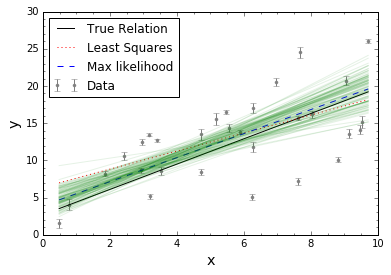

In [135]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.plot(x, m_ls * x + b_ls,
        color='red',
        ls=':',
        label='Least Squares')
ax.plot(x, ml_m * x + ml_b,
        color='blue',
        ls='--',
        label='Max likelihood')
for b, m, lnf in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x,
            m * x + b,
            color='green',
            alpha=0.1)
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

In [136]:
samples[:, 2] = np.exp(samples[:, 2])
b_mcmc, m_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("MCMC Parameter estimates:")
print("slope: {0:1.2f} (+{1:1.2f}, -{2:1.2f})".format(m_mcmc[0],
                                                        m_mcmc[1],
                                                        m_mcmc[2]))
print("y-intercept: {0:1.2f} (+{1:1.2f}, -{2:1.2f})".format(b_mcmc[0],
                                                        b_mcmc[1],
                                                        b_mcmc[2]))
print("\nTrue values:")
print("slope: {0:1.2f}".format(m_true))
print("y-intercept: {0:1.2f}".format(b_true))

MCMC Parameter estimates:
slope: 1.58 (+0.33, -0.33)
y-intercept: 4.05 (+1.60, -1.37)

True values:
slope: 1.70
y-intercept: 2.70


## Astrophysical Example: FIR SED

Let's say we have Herschel PACS+SPIRE photometry and we want to get the dust temperature...

In [137]:
from dust_emissivity.blackbody import modified_blackbody
import astropy.units as u

In [138]:
def fit_bb(x, *p):
    """
    simpler wrapper function to get the units right
    I don't care about the absolute amplitude, so the 1e-9 factor is just
    for numerical happiness.
    """
    return 1.e-9* p[1] * modified_blackbody((x*u.micron).to(u.Hz, equivalencies=u.spectral()),
                              p[0] * u.K,
                              beta=p[2],
                              kappa0=0.48*u.m**2/u.kg,
                              nu0=(250*u.micron).to('Hz', u.spectral())).to('Jy').value

In [139]:
FIRm = np.array([(70., 50., 2.6),
                 (100., 55., 2.3),
                 (160., 34., 1.6),
                 (250., 12., 0.8),
                 (350., 4.6, 0.3),
                 (500., 1.3, 0.1)],
                dtype=[('wave', float),
                       ('flux', float),
                       ('dflux', float)])
plotrange = np.arange(FIRm['wave'][0],
                      FIRm['wave'][-1],
                      1)

In [140]:
def lnlike(theta, x, y, yerr):
    T, amp, beta, lnf = theta
    model = fit_bb(x, T, amp, beta)
    inv_sigma2 = 1.0 / (yerr**2 + model**2*np.exp(2*lnf))
    return -0.5 * np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2))

In [141]:
# initial guesses. 25K, arbitrary 
p0 = [25, 1, 1.8, -1]
nll = lambda *args: -lnlike(*args)
maxlike = op.minimize(nll, p0,
                      args=(FIRm['wave'],
                            FIRm['flux'],
                            FIRm['dflux']),method='Nelder-Mead')
Tfit, Ampfit, betafit, lnffit = maxlike["x"]
print("Max likelihood:")
print("T: {0:1.1f} K".format(Tfit))
print("amp: {0:1.1f}".format(Ampfit))
print("beta: {0:1.2f}".format(betafit))

Max likelihood:
T: 32.5 K
amp: 9.9
beta: 1.84


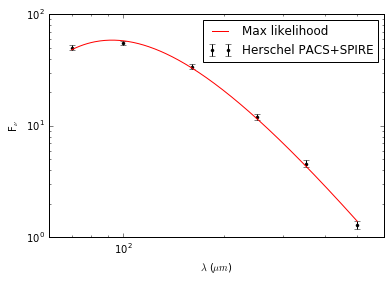

In [142]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(FIRm['wave'],
            FIRm['flux'],
            yerr=FIRm['dflux'],
            ls='',
            marker='.',
            color='black',
            label='Herschel PACS+SPIRE')
ax.plot(plotrange,
        fit_bb(plotrange,
               Tfit,
               Ampfit,
               betafit),
        color='red',
        label='Max likelihood')
ax.set_ylabel(r'F$_{\nu}$')
ax.set_xlabel('$\lambda$ ($\mu m$)')
ax.set_xlim([60, 600])
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best')

### MCMC

This will show how you might use informative priors.

Let's make sure it knows that the dust needs to be warmer than the CMB and that the amplitude needs to be positive.

Also, "normal" galaxies have dust temperatures of ~25 K, with a dispersion of a few 2K. Let's set the prior on temperature to be a Gaussian centered at 25 K with a sigma of 2.5K.

In [143]:
def lnprior(theta):
    T, amp, lnf, beta = theta
    if T >= 2.73 and amp > 0.:
        return -1 * (T - 25)**2 / (2 * 2.5**2)
    return -np.inf 

In [144]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [145]:
ndim, nwalkers = 4, 300
pos = [maxlike["x"] + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

Because of the larger parameter space and more complex model, this will take longer to run.

In [146]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args=(FIRm['wave'],
                                      FIRm['flux'],
                                      FIRm['dflux']),
                                threads=nthreads)
sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in mult

Again, look at the distribution of parameter estimates. But here, show the estimated parameters from the maximum likelihood model as the "true" values.

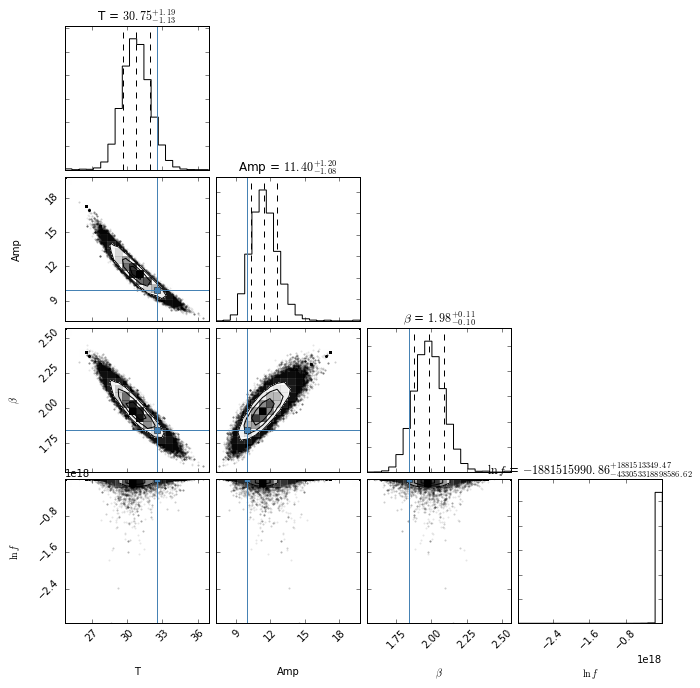

In [147]:
# show best-fit values as the "truth" values
fig = corner.corner(samples,
                    labels=["T", "Amp", r"$\beta$", r"$\ln\,f$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[Tfit, Ampfit, betafit, lnffit])

The offsets between the MCMC median values and the maximum likelihood are at least partially a consequence of our chosen prior on the temperature.

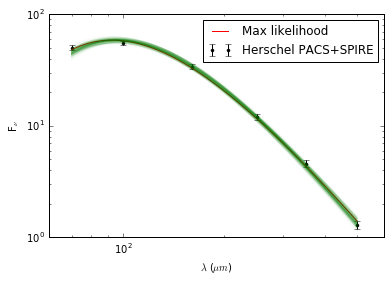

In [148]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(FIRm['wave'],
            FIRm['flux'],
            yerr=FIRm['dflux'],
            ls='',
            marker='.',
            color='black',
            label='Herschel PACS+SPIRE')
ax.plot(plotrange,
        fit_bb(plotrange,
               Tfit,
               Ampfit,
               betafit),
        color='red',
        label='Max likelihood')
for T, A, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(plotrange,
            fit_bb(plotrange, T, A, b),
            color='green',
            alpha=0.05)
ax.set_ylabel(r'F$_{\nu}$')
ax.set_xlabel('$\lambda$ ($\mu m$)')
ax.set_xlim([60, 600])
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best')

In [149]:
samples[:, 3] = np.exp(samples[:, 3])
T_mcmc, A_mcmc, beta_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                       zip(*np.percentile(samples, [16, 50, 84],
                                                          axis=0)))
print("MCMC Parameter estimates:")
print("T: {0:1.2f} (+{1:1.2f}, -{2:1.2f}) K".format(T_mcmc[0],
                                                  T_mcmc[1],
                                                  T_mcmc[2]))
print("beta: {0:1.2f} (+{1:1.2f}, -{2:1.2f})".format(beta_mcmc[0],
                                                     beta_mcmc[1],
                                                     beta_mcmc[2]))

MCMC Parameter estimates:
T: 30.75 (+1.19, -1.13) K
beta: 1.98 (+0.11, -0.10)


It is left to as an exercise to the reader to re-run the blackbody fitting with flat priors on the temperature and see how that changes the resulting fits.